In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
from matplotlib import pyplot as plt 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder 
import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings 
warnings.filterwarnings('ignore')   #ask
%config InLineBackend.figure_format = 'retina'


# # # # # #

In [2]:
train = pd.read_csv("train.csv")
train_dict = pd.read_csv("train_data_dict.csv")
test = pd.read_csv("test.csv")#sample thingy i didnt take yet
print(train.shape)
print(test.shape)


(318438, 18)
(137057, 17)


In [3]:
train.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [4]:
train.isnull().sum()


case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [5]:
test.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                              35
patientid                               0
City_Code_Patient                    2157
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
dtype: int64

In [6]:
train["Stay"].unique()

array(['0-10', '41-50', '31-40', '11-20', '51-60', '21-30', '71-80',
       'More than 100 Days', '81-90', '61-70', '91-100'], dtype=object)

In [7]:
label = LabelEncoder()
train["Stay"]= label.fit_transform(train["Stay"])

In [8]:
train["Stay"].value_counts()

2     87491
1     78139
3     55159
5     35018
0     23604
4     11743
7     10254
10     6683
8      4838
9      2765
6      2744
Name: Stay, dtype: int64

In [9]:
train["Flag"] = 0
test["Flag"] = 1    #tbasked
test["Stay"] = None
print(test.shape,train.shape)
df = pd.concat((train,test))
print(df.shape)

(137057, 19) (318438, 19)
(455495, 19)


In [10]:
cols= df.columns
for col in cols :
    print("Category:", col, "\tUniques:", df[col].nunique())

Category: case_id 	Uniques: 455495
Category: Hospital_code 	Uniques: 32
Category: Hospital_type_code 	Uniques: 7
Category: City_Code_Hospital 	Uniques: 11
Category: Hospital_region_code 	Uniques: 3
Category: Available Extra Rooms in Hospital 	Uniques: 18
Category: Department 	Uniques: 5
Category: Ward_Type 	Uniques: 6
Category: Ward_Facility_Code 	Uniques: 6
Category: Bed Grade 	Uniques: 4
Category: patientid 	Uniques: 131624
Category: City_Code_Patient 	Uniques: 37
Category: Type of Admission 	Uniques: 3
Category: Severity of Illness 	Uniques: 3
Category: Visitors with Patient 	Uniques: 29
Category: Age 	Uniques: 10
Category: Admission_Deposit 	Uniques: 7634
Category: Stay 	Uniques: 11
Category: Flag 	Uniques: 2


In [11]:
df.drop(['case_id','patientid'], axis = 1, inplace = True)
train.dtypes

case_id                                int64
Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                            float64
patientid                              int64
City_Code_Patient                    float64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                   int32
Flag                                   int64
dtype: object

<AxesSubplot:ylabel='Frequency'>

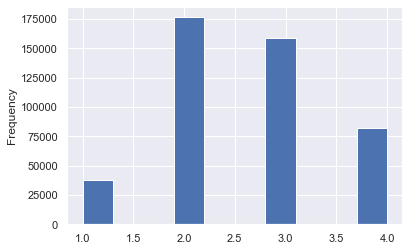

In [12]:
df['Bed Grade'].plot(kind='hist')

In [13]:
df['Bed Grade'].mean()

2.6284196447983628

In [14]:
df['Bed Grade'].median()


3.0

<AxesSubplot:ylabel='Frequency'>

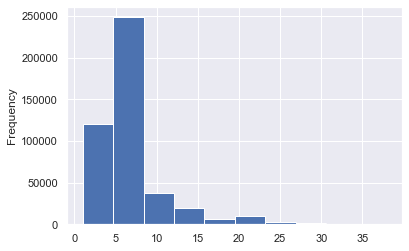

In [15]:
df['City_Code_Patient'].plot(kind='hist')

In [16]:
df['City_Code_Patient'].mean()

7.249495327602572

In [17]:
df['City_Code_Patient'].median()


8.0

In [18]:
df['Bed Grade'] = np.where(df['Bed Grade'].isna(), 3, df['Bed Grade'])
df['City_Code_Patient']= np.where(df['City_Code_Patient'].isna(),8, df['City_Code_Patient'])


In [19]:
df['Bed Grade'] = df['Bed Grade'].astype(int)
df['City_Code_Patient'] = df['City_Code_Patient'].astype(int)
df['Admission_Deposit']= df['Admission_Deposit'].astype(int)
df.dtypes

Hospital_code                         int64
Hospital_type_code                   object
City_Code_Hospital                    int64
Hospital_region_code                 object
Available Extra Rooms in Hospital     int64
Department                           object
Ward_Type                            object
Ward_Facility_Code                   object
Bed Grade                             int32
City_Code_Patient                     int32
Type of Admission                    object
Severity of Illness                  object
Visitors with Patient                 int64
Age                                  object
Admission_Deposit                     int32
Stay                                 object
Flag                                  int64
dtype: object

In [20]:
df.shape


(455495, 17)

In [21]:
colm = df.select_dtypes(['object']).columns 
colm


Index(['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type',
       'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness', 'Age',
       'Stay'],
      dtype='object')

In [22]:
colm = colm[:-1]
colm



Index(['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type',
       'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness',
       'Age'],
      dtype='object')

In [23]:
df = pd.get_dummies(data = df,columns= colm)
df.shape

(455495, 52)

In [24]:
df.dtypes

Hospital_code                         int64
City_Code_Hospital                    int64
Available Extra Rooms in Hospital     int64
Bed Grade                             int32
City_Code_Patient                     int32
Visitors with Patient                 int64
Admission_Deposit                     int32
Stay                                 object
Flag                                  int64
Hospital_type_code_a                  uint8
Hospital_type_code_b                  uint8
Hospital_type_code_c                  uint8
Hospital_type_code_d                  uint8
Hospital_type_code_e                  uint8
Hospital_type_code_f                  uint8
Hospital_type_code_g                  uint8
Hospital_region_code_X                uint8
Hospital_region_code_Y                uint8
Hospital_region_code_Z                uint8
Department_TB & Chest disease         uint8
Department_anesthesia                 uint8
Department_gynecology                 uint8
Department_radiotherapy         

In [25]:
train, test = df[df.Flag == 0],df[df.Flag == 1]
test.dtypes

Hospital_code                         int64
City_Code_Hospital                    int64
Available Extra Rooms in Hospital     int64
Bed Grade                             int32
City_Code_Patient                     int32
Visitors with Patient                 int64
Admission_Deposit                     int32
Stay                                 object
Flag                                  int64
Hospital_type_code_a                  uint8
Hospital_type_code_b                  uint8
Hospital_type_code_c                  uint8
Hospital_type_code_d                  uint8
Hospital_type_code_e                  uint8
Hospital_type_code_f                  uint8
Hospital_type_code_g                  uint8
Hospital_region_code_X                uint8
Hospital_region_code_Y                uint8
Hospital_region_code_Z                uint8
Department_TB & Chest disease         uint8
Department_anesthesia                 uint8
Department_gynecology                 uint8
Department_radiotherapy         

In [26]:
train.drop(['Flag'], inplace = True, axis = 1)
test.drop(['Flag'], inplace = True, axis = 1)
test.drop(['Stay'], inplace = True, axis = 1)
train['Stay'] = train['Stay'].astype(int)

In [27]:
train, eval = train_test_split(train,test_size= 0.30, random_state = 42, shuffle = True, stratify= train['Stay']) #tbasked

In [28]:
feature_cols = train.columns.tolist()
feature_cols.remove('Stay')
label_col = 'Stay'
print(feature_cols)

['Hospital_code', 'City_Code_Hospital', 'Available Extra Rooms in Hospital', 'Bed Grade', 'City_Code_Patient', 'Visitors with Patient', 'Admission_Deposit', 'Hospital_type_code_a', 'Hospital_type_code_b', 'Hospital_type_code_c', 'Hospital_type_code_d', 'Hospital_type_code_e', 'Hospital_type_code_f', 'Hospital_type_code_g', 'Hospital_region_code_X', 'Hospital_region_code_Y', 'Hospital_region_code_Z', 'Department_TB & Chest disease', 'Department_anesthesia', 'Department_gynecology', 'Department_radiotherapy', 'Department_surgery', 'Ward_Type_P', 'Ward_Type_Q', 'Ward_Type_R', 'Ward_Type_S', 'Ward_Type_T', 'Ward_Type_U', 'Ward_Facility_Code_A', 'Ward_Facility_Code_B', 'Ward_Facility_Code_C', 'Ward_Facility_Code_D', 'Ward_Facility_Code_E', 'Ward_Facility_Code_F', 'Type of Admission_Emergency', 'Type of Admission_Trauma', 'Type of Admission_Urgent', 'Severity of Illness_Extreme', 'Severity of Illness_Minor', 'Severity of Illness_Moderate', 'Age_0-10', 'Age_11-20', 'Age_21-30', 'Age_31-40', '

In [29]:
cat_cols = feature_cols
cat_cols.remove('Admission_Deposit')
cat_cols

['Hospital_code',
 'City_Code_Hospital',
 'Available Extra Rooms in Hospital',
 'Bed Grade',
 'City_Code_Patient',
 'Visitors with Patient',
 'Hospital_type_code_a',
 'Hospital_type_code_b',
 'Hospital_type_code_c',
 'Hospital_type_code_d',
 'Hospital_type_code_e',
 'Hospital_type_code_f',
 'Hospital_type_code_g',
 'Hospital_region_code_X',
 'Hospital_region_code_Y',
 'Hospital_region_code_Z',
 'Department_TB & Chest disease',
 'Department_anesthesia',
 'Department_gynecology',
 'Department_radiotherapy',
 'Department_surgery',
 'Ward_Type_P',
 'Ward_Type_Q',
 'Ward_Type_R',
 'Ward_Type_S',
 'Ward_Type_T',
 'Ward_Type_U',
 'Ward_Facility_Code_A',
 'Ward_Facility_Code_B',
 'Ward_Facility_Code_C',
 'Ward_Facility_Code_D',
 'Ward_Facility_Code_E',
 'Ward_Facility_Code_F',
 'Type of Admission_Emergency',
 'Type of Admission_Trauma',
 'Type of Admission_Urgent',
 'Severity of Illness_Extreme',
 'Severity of Illness_Minor',
 'Severity of Illness_Moderate',
 'Age_0-10',
 'Age_11-20',
 'Age_21

In [30]:
lgb_clf = LGBMClassifier(random_state=17)

In [31]:
lgb_clf.fit(train[feature_cols],train[label_col])


LGBMClassifier(random_state=17)

In [32]:
eval_score = accuracy_score(eval[label_col], lgb_clf.predict(eval[feature_cols]))

print('Eval ACC: {}'.format(eval_score))

Eval ACC: 0.4198174433697609


In [33]:
param_grid = {'num_leaves' : [7,16, 50], 'max_depth' : [3, 6, 8,-1]}

In [34]:
grid_searcher = GridSearchCV(estimator=lgb_clf, param_grid=param_grid, 
                             cv=5, verbose=1, n_jobs=4)

In [35]:
grid_searcher.fit(train[feature_cols], train[label_col]) #tbasked

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=17), n_jobs=4,
             param_grid={'max_depth': [3, 6, 8, -1], 'num_leaves': [7, 16, 50]},
             verbose=1)

In [36]:
grid_searcher.best_params_, grid_searcher.best_score_

({'max_depth': 8, 'num_leaves': 50}, 0.41888059346567097)

In [37]:
accuracy_score(eval[label_col], grid_searcher.predict(eval[feature_cols]))

0.41989071724657706

In [38]:
num_iterations = 200
lgb_clf2 = LGBMClassifier(random_state = 17, max_depth = 8, num_leaves = 50, n_estimators = num_iterations, n_jobs = 2)
param_grid2 = {'learning_rate' : np.logspace(-3,0,10)}
grid_searcher2 = GridSearchCV(estimator=lgb_clf2, param_grid=param_grid2, cv=5, verbose=1, n_jobs= 4)
grid_searcher2.fit(train[feature_cols], train[label_col])
print(grid_searcher2.best_params_, grid_searcher2.best_score_)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'learning_rate': 0.046415888336127774} 0.41947277298472274


In [62]:
params = {}
params['learning_rate'] = 0.046
params['max_depth'] = 8
params['num_leaves'] = 50
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['n_estimators'] = 500
params['n_jobs'] = 4



In [63]:
clf = lgb.LGBMClassifier(**params)
    
clf.fit(train[feature_cols], train[label_col], early_stopping_rounds=100, eval_set=[(train[feature_cols], train[label_col]), (eval[feature_cols], eval[label_col])], eval_metric='multi_error', verbose=True, categorical_feature=cat_cols)
eval_score = accuracy_score(eval[label_col], clf.predict(eval[feature_cols]))
print('Eval ACC: {}'.format(eval_score))

[1]	valid_0's multi_error: 0.725247	valid_0's multi_logloss: 1.85483	valid_1's multi_error: 0.725254	valid_1's multi_logloss: 1.85629
[2]	valid_0's multi_error: 0.711735	valid_0's multi_logloss: 1.82208	valid_1's multi_error: 0.711856	valid_1's multi_logloss: 1.82462
[3]	valid_0's multi_error: 0.694557	valid_0's multi_logloss: 1.79462	valid_1's multi_error: 0.694867	valid_1's multi_logloss: 1.79803
[4]	valid_0's multi_error: 0.66755	valid_0's multi_logloss: 1.77107	valid_1's multi_error: 0.669482	valid_1's multi_logloss: 1.77529
[5]	valid_0's multi_error: 0.648852	valid_0's multi_logloss: 1.75021	valid_1's multi_error: 0.651059	valid_1's multi_logloss: 1.75521
[6]	valid_0's multi_error: 0.631504	valid_0's multi_logloss: 1.73151	valid_1's multi_error: 0.632804	valid_1's multi_logloss: 1.73731
[7]	valid_0's multi_error: 0.618637	valid_0's multi_logloss: 1.71478	valid_1's multi_error: 0.619667	valid_1's multi_logloss: 1.72136
[8]	valid_0's multi_error: 0.606942	valid_0's multi_logloss: 1.

[62]	valid_0's multi_error: 0.567396	valid_0's multi_logloss: 1.48988	valid_1's multi_error: 0.580989	valid_1's multi_logloss: 1.53112
[63]	valid_0's multi_error: 0.567131	valid_0's multi_logloss: 1.48876	valid_1's multi_error: 0.580842	valid_1's multi_logloss: 1.53064
[64]	valid_0's multi_error: 0.566934	valid_0's multi_logloss: 1.48771	valid_1's multi_error: 0.580633	valid_1's multi_logloss: 1.5302
[65]	valid_0's multi_error: 0.566723	valid_0's multi_logloss: 1.48661	valid_1's multi_error: 0.580622	valid_1's multi_logloss: 1.52973
[66]	valid_0's multi_error: 0.566467	valid_0's multi_logloss: 1.48557	valid_1's multi_error: 0.580444	valid_1's multi_logloss: 1.52929
[67]	valid_0's multi_error: 0.566136	valid_0's multi_logloss: 1.48453	valid_1's multi_error: 0.580476	valid_1's multi_logloss: 1.52885
[68]	valid_0's multi_error: 0.565889	valid_0's multi_logloss: 1.48356	valid_1's multi_error: 0.580381	valid_1's multi_logloss: 1.52848
[69]	valid_0's multi_error: 0.565718	valid_0's multi_log

[123]	valid_0's multi_error: 0.554821	valid_0's multi_logloss: 1.44332	valid_1's multi_error: 0.579104	valid_1's multi_logloss: 1.51829
[124]	valid_0's multi_error: 0.554839	valid_0's multi_logloss: 1.44278	valid_1's multi_error: 0.579115	valid_1's multi_logloss: 1.51822
[125]	valid_0's multi_error: 0.554588	valid_0's multi_logloss: 1.44222	valid_1's multi_error: 0.57922	valid_1's multi_logloss: 1.51814
[126]	valid_0's multi_error: 0.554278	valid_0's multi_logloss: 1.44169	valid_1's multi_error: 0.579272	valid_1's multi_logloss: 1.51805
[127]	valid_0's multi_error: 0.55413	valid_0's multi_logloss: 1.44115	valid_1's multi_error: 0.579157	valid_1's multi_logloss: 1.518
[128]	valid_0's multi_error: 0.554023	valid_0's multi_logloss: 1.44057	valid_1's multi_error: 0.578979	valid_1's multi_logloss: 1.51791
[129]	valid_0's multi_error: 0.553929	valid_0's multi_logloss: 1.44007	valid_1's multi_error: 0.578895	valid_1's multi_logloss: 1.51787
[130]	valid_0's multi_error: 0.553866	valid_0's mult

[184]	valid_0's multi_error: 0.544656	valid_0's multi_logloss: 1.41461	valid_1's multi_error: 0.578748	valid_1's multi_logloss: 1.51602
[185]	valid_0's multi_error: 0.544431	valid_0's multi_logloss: 1.41423	valid_1's multi_error: 0.578654	valid_1's multi_logloss: 1.516
[186]	valid_0's multi_error: 0.544324	valid_0's multi_logloss: 1.41383	valid_1's multi_error: 0.57878	valid_1's multi_logloss: 1.516
[187]	valid_0's multi_error: 0.544108	valid_0's multi_logloss: 1.41343	valid_1's multi_error: 0.578696	valid_1's multi_logloss: 1.51601
[188]	valid_0's multi_error: 0.543987	valid_0's multi_logloss: 1.41304	valid_1's multi_error: 0.578612	valid_1's multi_logloss: 1.51601
[189]	valid_0's multi_error: 0.543731	valid_0's multi_logloss: 1.41265	valid_1's multi_error: 0.578361	valid_1's multi_logloss: 1.51599
[190]	valid_0's multi_error: 0.543637	valid_0's multi_logloss: 1.41221	valid_1's multi_error: 0.578424	valid_1's multi_logloss: 1.51597
[191]	valid_0's multi_error: 0.54348	valid_0's multi_

[245]	valid_0's multi_error: 0.535674	valid_0's multi_logloss: 1.39182	valid_1's multi_error: 0.577492	valid_1's multi_logloss: 1.51525
[246]	valid_0's multi_error: 0.53545	valid_0's multi_logloss: 1.39142	valid_1's multi_error: 0.577576	valid_1's multi_logloss: 1.51523
[247]	valid_0's multi_error: 0.53536	valid_0's multi_logloss: 1.39112	valid_1's multi_error: 0.577597	valid_1's multi_logloss: 1.51523
[248]	valid_0's multi_error: 0.535262	valid_0's multi_logloss: 1.39079	valid_1's multi_error: 0.577587	valid_1's multi_logloss: 1.51523
[249]	valid_0's multi_error: 0.535221	valid_0's multi_logloss: 1.3904	valid_1's multi_error: 0.57767	valid_1's multi_logloss: 1.51522
[250]	valid_0's multi_error: 0.535019	valid_0's multi_logloss: 1.39003	valid_1's multi_error: 0.57766	valid_1's multi_logloss: 1.5152
[251]	valid_0's multi_error: 0.534835	valid_0's multi_logloss: 1.38969	valid_1's multi_error: 0.577649	valid_1's multi_logloss: 1.51517
[252]	valid_0's multi_error: 0.534683	valid_0's multi_

[306]	valid_0's multi_error: 0.527101	valid_0's multi_logloss: 1.37089	valid_1's multi_error: 0.577827	valid_1's multi_logloss: 1.51514
[307]	valid_0's multi_error: 0.527025	valid_0's multi_logloss: 1.37058	valid_1's multi_error: 0.577859	valid_1's multi_logloss: 1.51516
[308]	valid_0's multi_error: 0.526917	valid_0's multi_logloss: 1.37022	valid_1's multi_error: 0.577806	valid_1's multi_logloss: 1.51515
[309]	valid_0's multi_error: 0.526679	valid_0's multi_logloss: 1.36991	valid_1's multi_error: 0.577838	valid_1's multi_logloss: 1.51515
[310]	valid_0's multi_error: 0.526545	valid_0's multi_logloss: 1.36955	valid_1's multi_error: 0.577901	valid_1's multi_logloss: 1.51513
[311]	valid_0's multi_error: 0.526406	valid_0's multi_logloss: 1.36917	valid_1's multi_error: 0.577911	valid_1's multi_logloss: 1.51511
[312]	valid_0's multi_error: 0.526365	valid_0's multi_logloss: 1.36883	valid_1's multi_error: 0.577984	valid_1's multi_logloss: 1.51511
[313]	valid_0's multi_error: 0.526235	valid_0's 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'n_estimators': 300} 0.4196118422624885


In [ ]:
clf = lgb.LGBMClassifier(**params)

clf.fit(train[feature_cols], train[label_col], eval_metric='multi_error', verbose=False, categorical_feature=cat_cols)

eval_score_acc = accuracy_score(train[label_col], clf.predict(train[feature_cols]))

print('ACC: {}'.format(eval_score_acc))

In [ ]:
preds = clf.predict(test[feature_cols])
preds

In [ ]:
plt.rcParams['figure.figsize'] = (12,50)
lgb.plot_importance(clf)
plt.show()

In [ ]:
preds = label.inverse_transform(preds)
preds

In [ ]:
test1 = pd.read_csv("test.csv")

In [ ]:
submit = pd.DataFrame({'case_id': test1.case_id, 'Stay': preds})

In [ ]:
submit.head()

In [ ]:
submit.to_csv('submissionjhhalgcccc.csv', index=False)